# Functional Text Extraction 
## Summary
In this notebook, we will go over some of the tools that can be used to extract text from various formats. Text will be extracted from PDFs, docx and tables embedded in PDF documents. The techniques in this notebook are just some of many that exist but should provide a basic flow for how to do this sort of work to structure unstructured data for use in a database or other friendly format. 

## Introduction
Often, storage formats selected by non-technical users do not conform to good practices for sharing or long term storage. For this reason, there are many different tools that have been developed in languages like Python that can help us pull data out of these unfriendly formats. 

PDFs are often selected as a storage format as PDFs are a portable format. This means that a PDF generated on one machine will always look the same on a second computer regardless of how it was generated or how it is being viewed. Especially with the advent of the PDF/A (PDF/archive) format, people use PDFs as a means for long term storage of critical data.  

This howerver, results in a lot of headaches for developers. PDFs, by nature, are often flattened and can be inaccessible to machines. In some instances, they are essentially flat images stored as PDFs that cannot be read by a machine. In other cases, they are machine readable but can be difficult to work with. 

## Purpose
I have had to use many of these techniques in order to structure unstructured data for work. The end goal usually was to get the data into a state where I could share it with an end user or get the data uploaded into a database. 

## The Basic Flow
The hardest part of working with PDFs is getting the data out of the PDFs. 

This is the basic flow of how I usually approach any PDF that I have to extract data from:

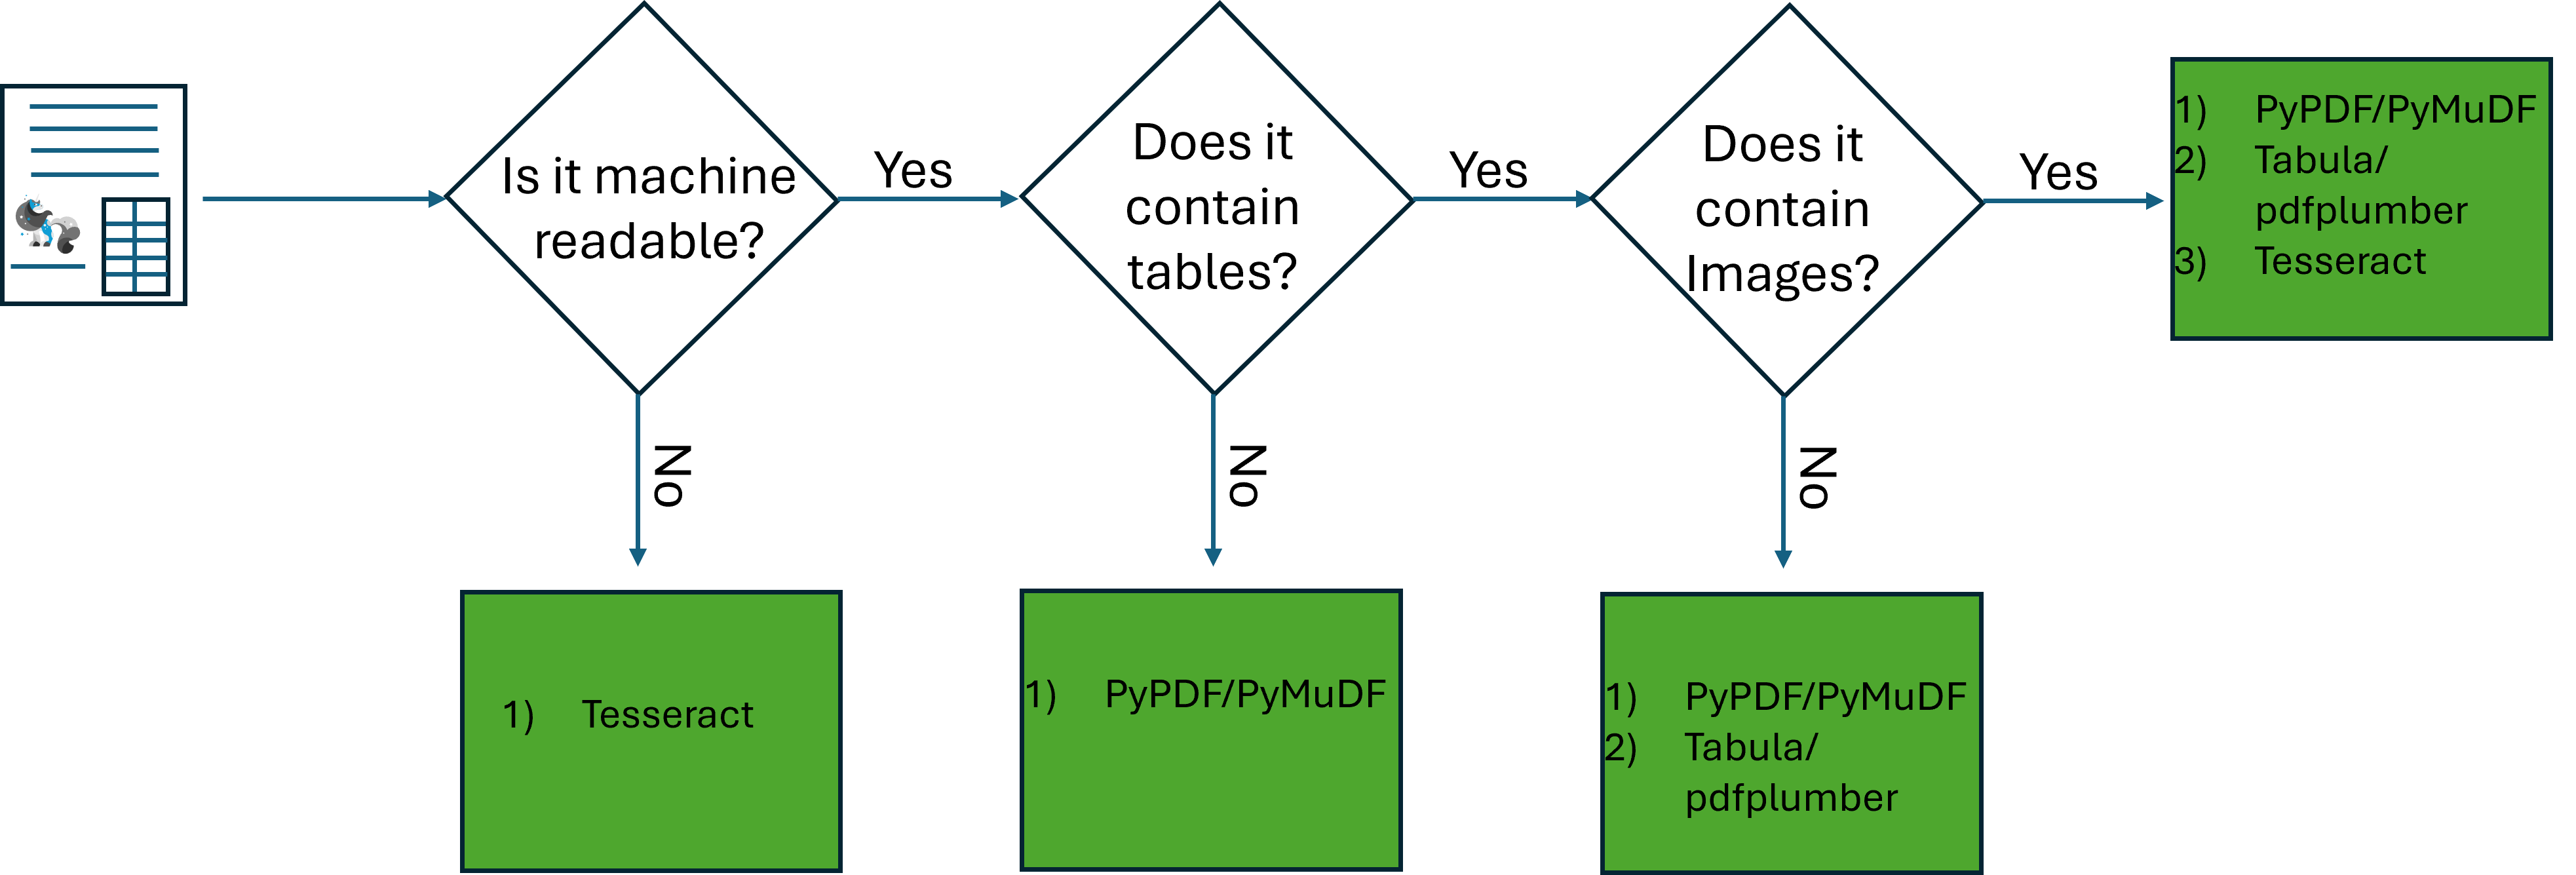


## Environment Setup
I have two example PDFs. One single coulmn and one multicolumn. 

In [ ]:
single_column = 'single_column.pdf'
multi_column = 'multi_column.pdf'
#!pip install pypdf
#!pip install PyMuPDF

### PDF Text Extraction

#### PyPDF/PyPDF2
PyPDF has been around for a very long time. PyPDF2 was started to add some additional functionality and continue the development started in PyPDF. Recently, PyPDF2 has been merged with PyPDF and the new package is extremely powerful. I use PyPDF a lot and it is often used as the gold standard for text extraction for LLM pipelines. It is reasonably fast but can be very accurate (as accurate as you can be with PDF text extraction) 

#### PyMuPDF
PyMuPDF relies on fitz which is a C engine that is fairly well developed. I usually use it as a backup to when PyPDF cannot read a PDF as PyPDF has a much more active community of developers right now. Sometimes I find that PyMuPDF makes some weird errors, especially when it is a multi-column PDF. These are often found in scientific papers. PyMuPDF is faster and can generally be a great choice. 

PyMuPDF imports as **fitz**

We will see this later, but the fitz engine can be used to help us pull data from images. 

##### Single Column PDF

PyPDF example

In [ ]:
from pypdf import PdfReader
doc = PdfReader(single_column)
#Specific page that we need. 
page = doc.pages[0]
text = page.extract_text()
print(text)

PyMuPDF example (as fitz)

In [ ]:
import fitz
doc = fitz.open(single_column)
page = doc.load_page(0)
page_to_text = page.get_text("text")
print(page_to_text)

Show explicit differences in string readings between the libraries

In [7]:
import difflib

# Use Differ to compare the strings
differ = difflib.Differ()
diff = differ.compare(text.splitlines(), page_to_text.splitlines())

# Join the result into a single string with line breaks
result = '\n'.join(diff)

# Output the differences
with open('diff_output.txt', 'w') as file:
    file.write(result)

##### Multicolumn PDF

In [ ]:
from pypdf import PdfReader
doc = PdfReader(multi_column)
#Specific page that we need. 
page = doc.pages[0]
text = page.extract_text()
print(text)

In [ ]:
import fitz
doc = fitz.open(multi_column)
page = doc.load_page(0)
page_to_text = page.get_text("text")
print(page_to_text)

#### PDF Text Extractor Choice Flow

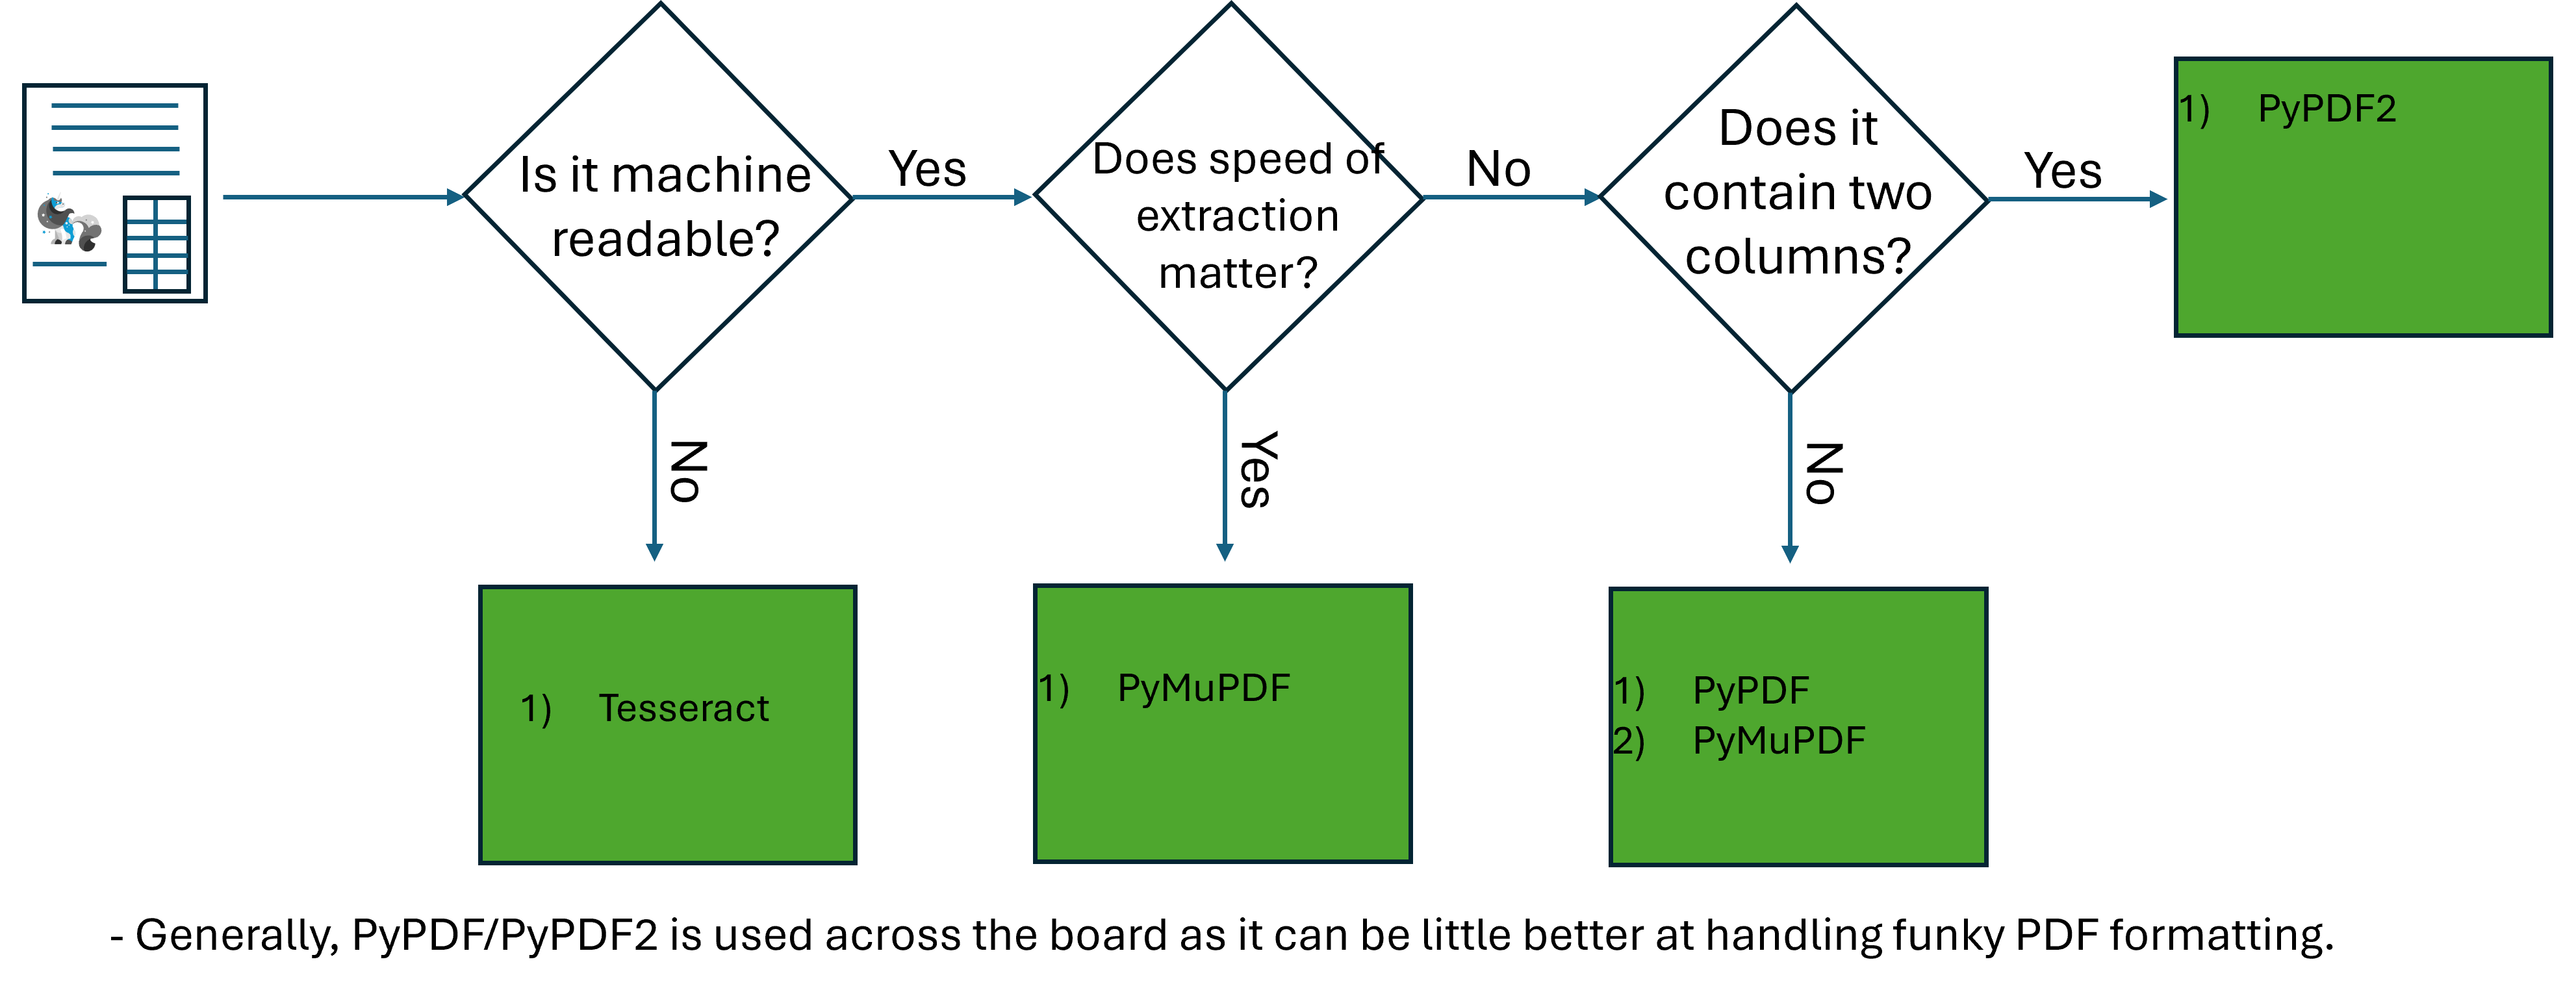

### Table Extraction

There are a lot different tools out there for table extraction. Some are much better than others. Here we will look at two of my favorite ones, Tabula and PDFPlumber

#### Tabula
Tabula requires a configured Java Runtime Environment to work well. I use Amazon's Coretto. 
**https://aws.amazon.com/corretto**

This stackoverflow thread will help you understand JRE configuration. 
**https://stackoverflow.com/questions/54817211/java-command-is-not-found-from-this-python-process-please-ensure-java-is-inst**

Make sure that Coretto is in your PATH or Tabula will not work. 

When you pass the all parameter to tabula, it pulls every table as its own indexed df. This way you can pull specific tables by order or split out each table as its own csv/table for later use. 

In [ ]:
dfs = tabula.read_pdf(single_column, pages='all')
print(dfs)
df = pd.concat(dfs)
display(df)

Tabula really hates it when you pass a multi column text as it treats each column as a column in a table. For this reason, it might be useful to try a different table engine or specifically target the page with the table for the PDF you are extracting. 

In [ ]:
dfs = tabula.read_pdf(multi_column, pages='all')
print(dfs)
df = pd.concat(dfs)
display(df)

#### PdfPlumber

PDFPlumber does not need a configured JRE to function. I have used this in instances where I do not have acces to Java or want to keep my code to not being reliant on anything that can't just be pip-ed. 

In [ ]:
#!pip install pdfplumber
import pdfplumber

table_settings={"vertical_strategy": "text", 
                "horizontal_strategy": "text"}

with pdfplumber.open(single_column) as pdf:
    page = pdf.pages[33]    
    table = page.extract_table(table_settings = table_settings)
    
    df = pd.DataFrame(table)

    display(df)

Much like with Tabula, pdfplumber and many of the other PDF miners panic when they are exposed to multi-column PDFs. This can be mitigated by knowning where the table is in the document but if not, you end up with each column of your text and each new line as a columns and rows in a psuedo-table. 

There is a lot of depth to the configuration of both of these tools and your preference will depend on what you are attempting to do with data and what you have to handle. 

In [ ]:
table_settings={"vertical_strategy": "text", 
                "horizontal_strategy": "text"}

with pdfplumber.open(multi_column) as pdf:
    total_pages = len(pdf.pages)
    for page in range(total_pages):
        page = pdf.pages[page]    
        table = page.extract_table(table_settings = table_settings)
    
        df = pd.DataFrame(table)

        display(df)

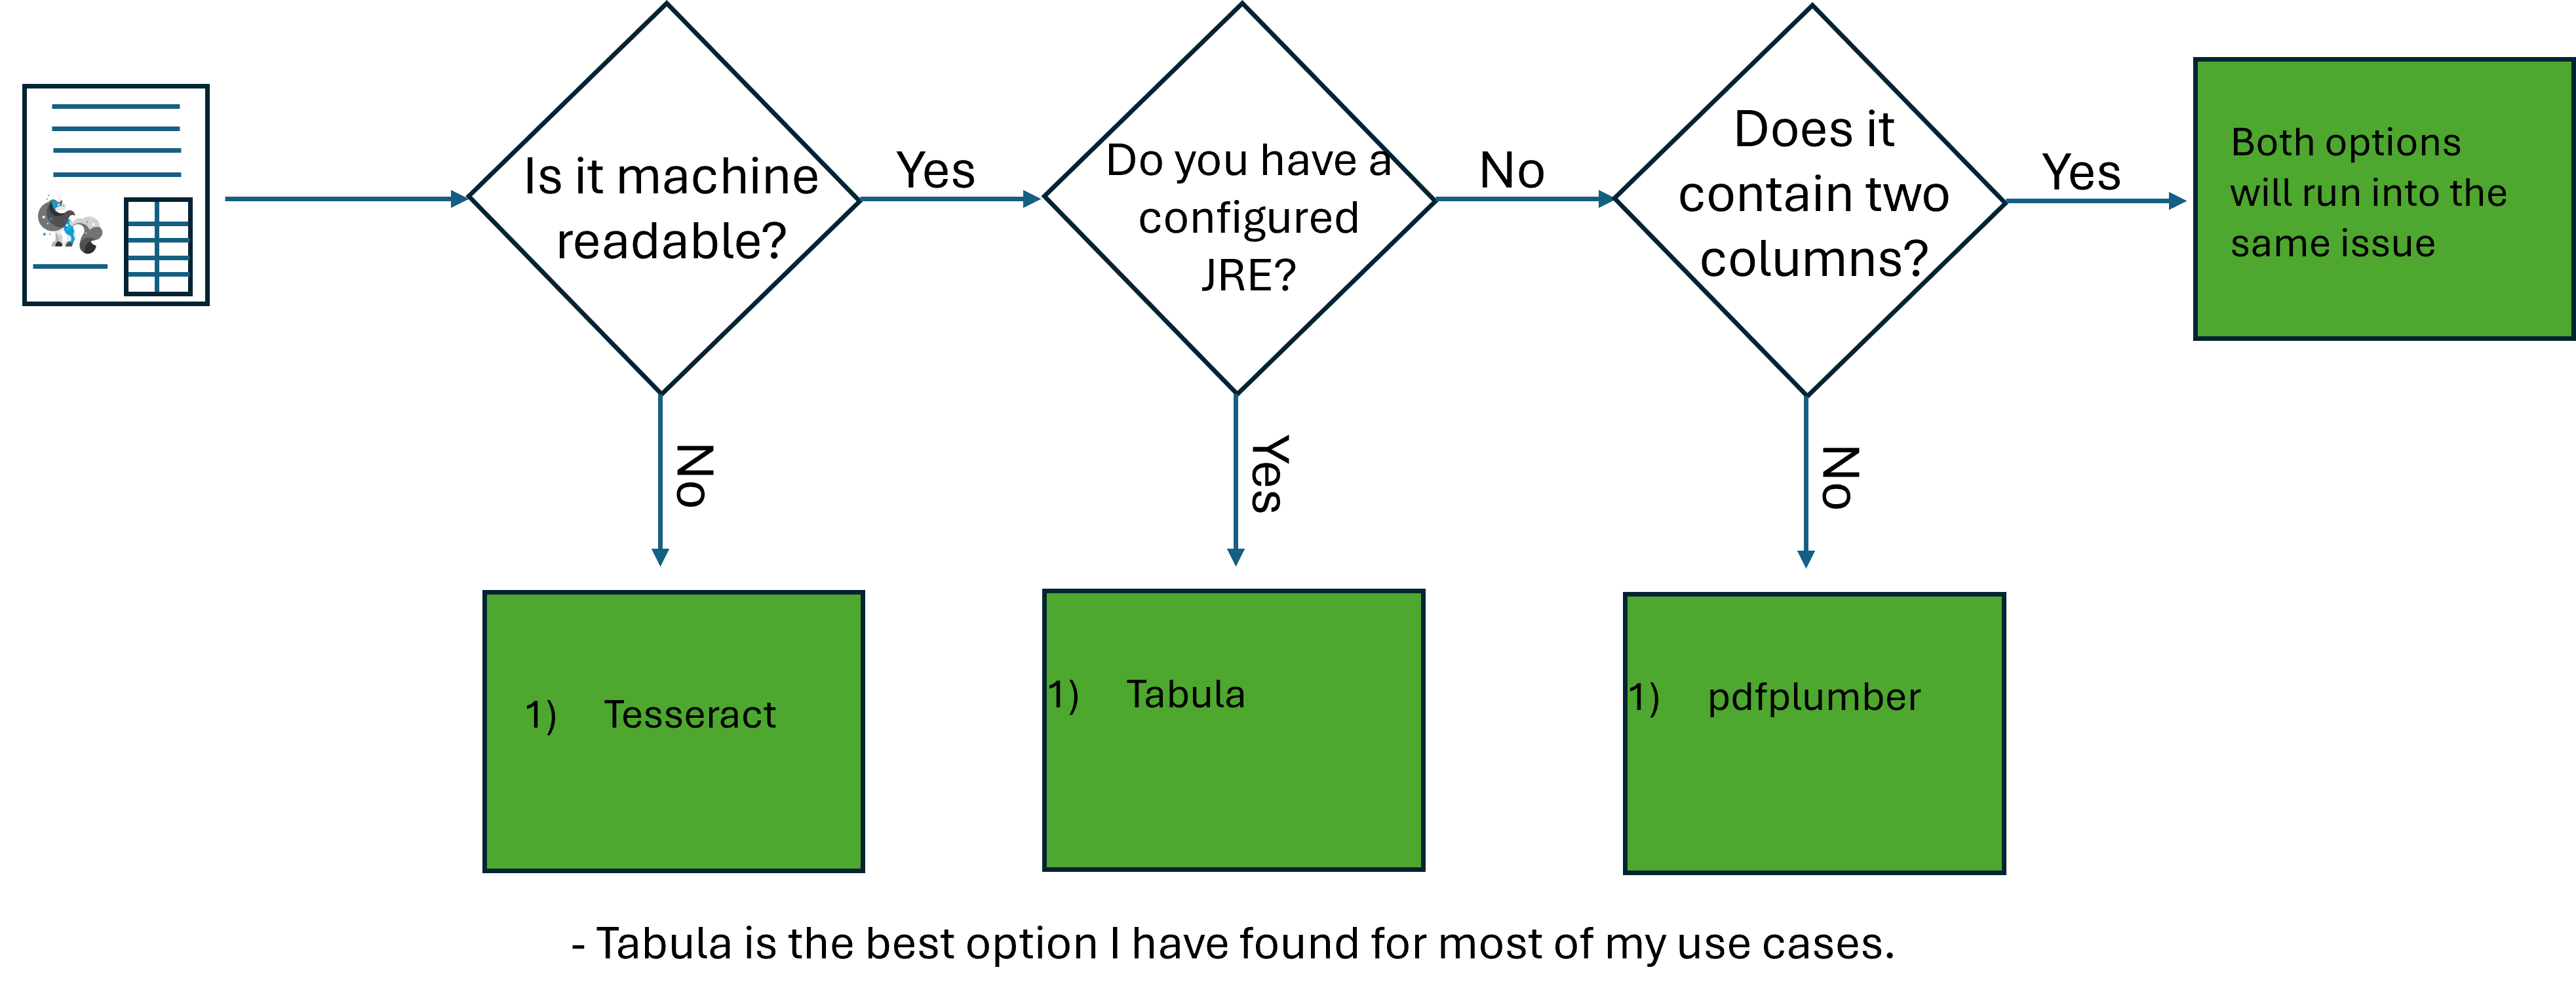

### OCR for Text Extraction

#### Tesseract
Tesseract is an open source Optical Character Recognition engine. It is fast, powerful and fairly lightweight. It was built in collaboration with reserachers from Google as well as academic institutions. 

To get tesseract to work, you need to install the tesseract OCR engine: 
**https://github.com/UB-Mannheim/tesseract/wiki**

You will also need to install pytesseract and OpenCV to help extract the images to run the OCR.

##### Extract the Image for OCR
We will use fitz to pop the image out of the PDF so that we can point the OCR engine at it. 

In [ ]:
import fitz
doc = fitz.open(single_column)
img_page = doc.load_page(28)
pix = img_page.get_pixmap()
pix.save('image.png')
doc.close()

We will target the extracted image to pull the text. 

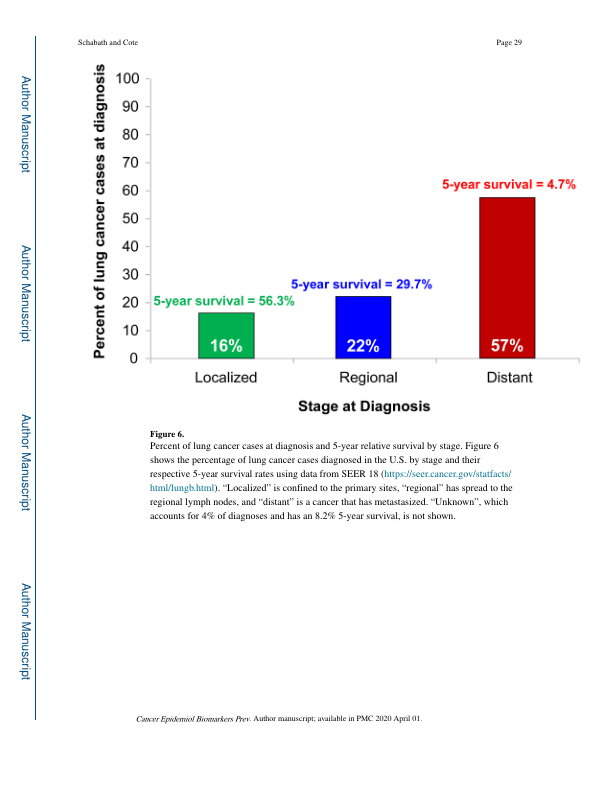

In [ ]:
import cv2 
import pytesseract
img = cv2.imread('image.png')
custom_config = r'--oem 3 --psm 6'
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
text = pytesseract.image_to_string(img, config=custom_config)
print(text)

## Putting it all together.
I created a document using an LLM and we will extract the data out of it using the flow that I laid out.

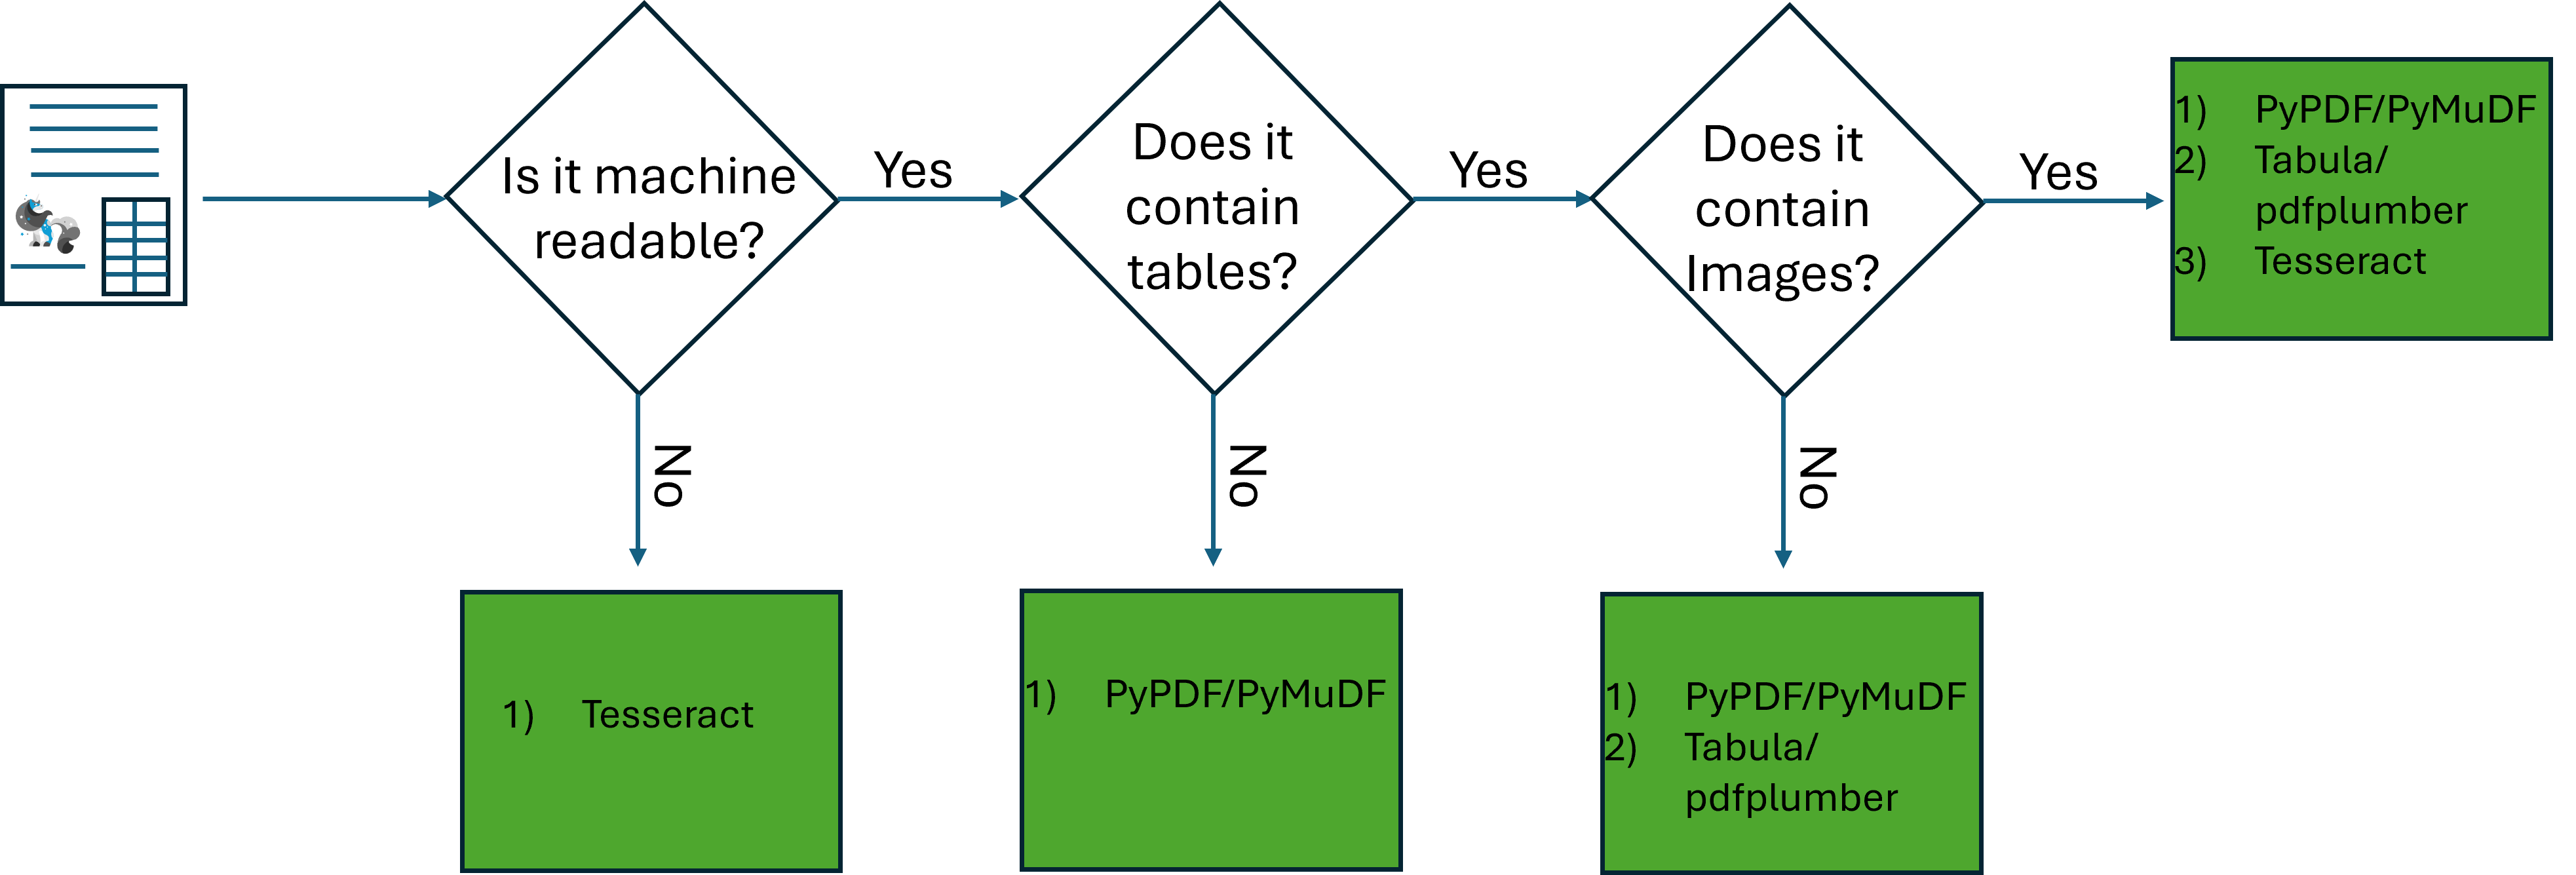

In [ ]:
def pdf_to_txt(file):
    import fitz
    import re
    page_num = 0
        
    file_name = (file.rsplit('\\', 1)[1]).rsplit('.', 1)[0]
    out_path = file.rsplit("\\", 1)[0]
    print("Converting: " + file_name)
    
    with fitz.open(file) as doc:      
        text = ""
        for page in doc:
            page_text = ""
            print(page_num)
            page_text = page.get_text()
            tess_test_str = re.sub(r"[\n\t\s]*", "", page_text)
            
            #if len(tess_test_str.replace(" ", "")) > 0:
            if len(tess_test_str) > 0:
                text = text + '\n' + page_text
            else:
                print("to the OCR pipe")
                text = text + '\n' + tesseract_ocr(image_extract(page_num, file, out_path, file_name))
                
            page_num = page_num + 1
                          
    out_path_txt = out_path + "\\" + file_name + '.txt'
    with open(out_path_txt, "w", encoding="utf-8") as text_file:
        text_file.write(text)
        
    table_extract(file, out_path, file_name)
    

def image_extract(page_num, file, out_path, file_name):
    import fitz
    doc = fitz.open(file)
    img_page = doc.load_page(page_num)
    pix = img_page.get_pixmap()
    img_file_name = file_name + '_' + str(page_num) + ".png"
    output = out_path + "\\" + img_file_name
    pix.save(output)
    doc.close()
    return(output)

def tesseract_ocr(output):
    import cv2 
    import pytesseract
    img = cv2.imread(output)
    custom_config = r'--oem 3 --psm 6'
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
    text = pytesseract.image_to_string(img, config=custom_config)
    return text
    
def table_extract(file, out_path, file_name):
    import tabula
    out_path_csv = out_path + '\\' + file_name +'.csv'
    tabula.convert_into(file, out_path_csv, output_format="csv", pages="all")

In [ ]:
file = r"C:\Users\rajur\OneDrive\Documents\frederick_text_extract_session\MD_tess_doc.pdf"

In [ ]:
pdf_to_txt(file)